The general idea here is to drop in some image of a planetary body (let's face it, Mars) together with the distance to the planet and the diameter of the telescope in question and to get back a number corresponding to how close to the diffraction limit the image is.

In [115]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import scipy.interpolate as si

In [15]:
path = "/home/handmer/Documents/Mars/Telescope/"
file = "AnthonyWesley.jpeg"

In [16]:
def getImage(path):
    return np.asarray(Image.open(path))

In [31]:
imraw = getImage(path+file)

In [18]:
def imagePlot(array):
    plt.figure(figsize=(8,8))
    plt.imshow(array)

In [36]:
im = imraw[:580]

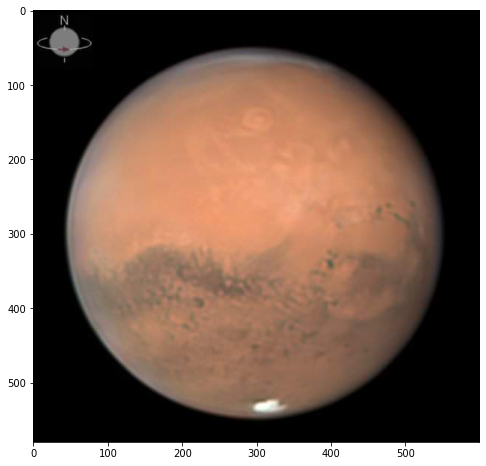

In [37]:
imagePlot(im)

Need to work out how many pixels wide Mars is, then how many pixels wide the limit of resolution is. Then we can calculate the limit of resolution in km. Divide by distance to Mars to get angular resolution.

In [71]:
def howWide(array):
    #array may need to be cropped to have just the image on a black background
    bwim = np.sum(im.astype(np.int16),axis=2)
    binarized = 0.5+0.5*np.sign(bwim-(np.mean(bwim)-np.var(bwim)**0.5))
    third = int(np.shape(binarized)[0]/3)
    horDiam = np.max(np.sum(binarized[third:-third],axis=1))
    verDiam = np.max(np.sum(temp[:,third:-third],axis=0))
    return [horDiam,verDiam]

In [72]:
howWide(im)

[512.0, 504.0]

Mars radius equatorial 3396.2, polar 3376.2.

Let's work out the limit of resolution using ... ffts!

In [94]:
def interiorCrop(im, width):
    half = (np.array(np.shape(im)[:2])/2).astype(np.int)
    size = int(width/3.2)
    return im[half[0]-size:half[0]+size,half[1]-size:half[1]+size]

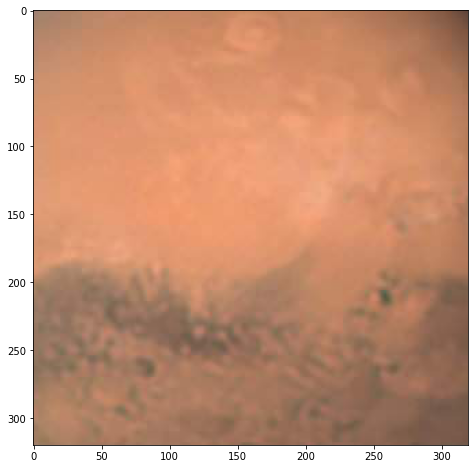

In [95]:
imagePlot(interiorCrop(im,512))

In [107]:
def FT(crop):
    bwim = np.sum(crop,axis=2)
    half = (np.array(np.shape(crop)[:2])/2).astype(np.int)
    logabsfft =  np.log(np.abs(np.fft.fft2(bwim)))
    return np.roll(logabsfft,half,axis=(0,1))

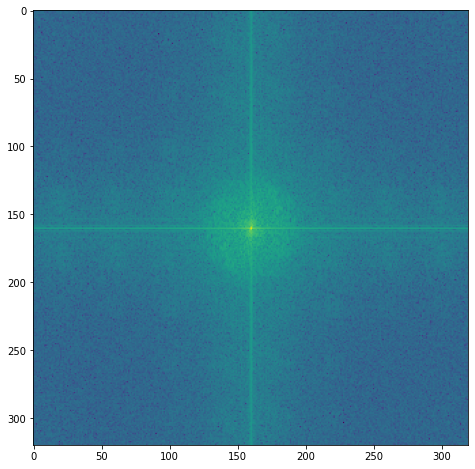

In [108]:
imagePlot(FT(interiorCrop(im,512)))

There's a fairly obvious edge to the power spectrum above. Let's quantify it.

In [116]:
def generateInterp(fft):
    half = (np.array(np.shape(fft)[:2])/2).astype(np.int)
    return si.RectBivariateSpline(np.arange(-half[0],half[0],1),
                                       np.arange(-half[0],half[0],1),
                                       fft, kx=1, ky=1)

In [117]:
interp = generateInterp(FT(interiorCrop(im,512)))

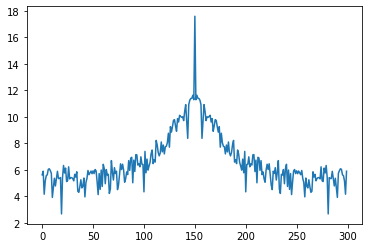

In [128]:
plt.plot(np.array([interp(i,i)[0,0] for i in np.arange(-150,150)]))

In [138]:
def radialProfile(interp,rad):
    return [np.mean([interp(r*np.sin(t),r*np.cos(t)) for t in np.arange(0,2*np.pi,2*np.pi/200.)]) for r in range(0,rad)]

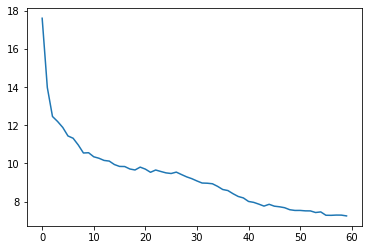

In [139]:
plt.plot(radialProfile(interp,60))

The inflection poin at r = 36 or so is the place we need to identify. Preferably automatically. 

In [146]:
def calculateSurfaceRes(fft,pixWide,rad):
    # Put in rad manually.
    pixRes = np.shape(fft)[0]/rad
    kmPerPix = np.array([2*3396.2,2*3376.2])/pixWide
    kmResolved = pixRes*np.mean(kmPerPix)
    # estimate error
    relErr = ((kmPerPix[1]-kmPerPix[0])/np.mean(kmPerPix)**2+rad**-2)**0.5
    return [kmResolved,relErr]
    

In [210]:
calculateSurfaceRes(FT(interiorCrop(im,512)),howWide(im),38)

[112.26958020050125, 0.0378251106805367]

Put in distance to Mars.

In [145]:
EarthMarsDist = 62070000 # On October 6 2020, very close opposition.

In [221]:
def ScopePowerTest(SurfRes, Dist, ScopeDiameter):
    # SurfRes, Dist in km, ScopeDiameter in m.
    angRes = SurfRes/Dist
    RayleighLimit = 1.22*0.0000005/ScopeDiameter
    return RayleighLimit/angRes

In [230]:
ScopePowerTest(112,EarthMarsDist,0.5715)

0.5915307461567304

Put it all together

In [227]:
def plotAngularScale(im):
    wid = int(howWide(im)[0])
    fft = FT(interiorCrop(im,wid))
    
    imagePlot(fft)
    plt.show()
    
    interp = generateInterp(fft)
    
    radProf = np.array(radialProfile(interp,int(np.shape(fft)[0]/2)))
    pltRange = [i for i in range(int(np.shape(fft)[0]/80),int(np.shape(fft)[0]/4))]
                
    plt.figure(figsize=(8,6))
    plt.plot(pltRange,radProf[pltRange])
    print("Determine x coordinate of right most change in concavity.")
    
def ScopePower(im, scopeDiamMeters, xCoord):
    surRes = calculateSurfaceRes(FT(interiorCrop(im,howWide(im)[0])),howWide(im),xCoord)
    sP = ScopePowerTest(surRes[0],EarthMarsDist,scopeDiamMeters)
    print("The image resolution is "+str(int(100*sP)/100.0) + "+-"+str(int(100*sP*surRes[1])/100.0)+" of the theoretical limit.")
    #return [sP, sP*surRes[1]]

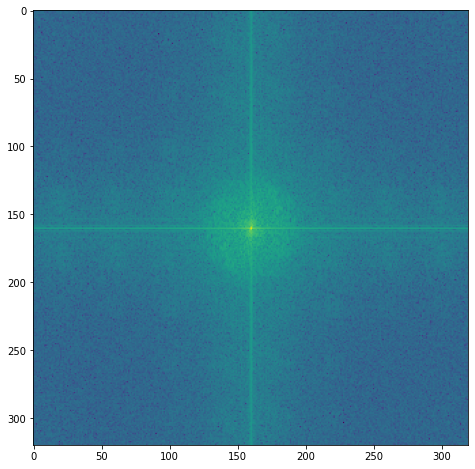

Determine x coordinate of right most change in concavity.


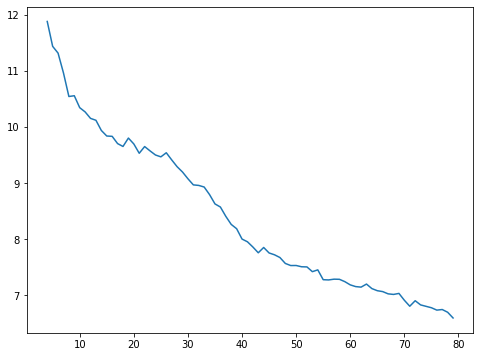

In [228]:
plotAngularScale(im)

In [231]:
ScopePower(im, 0.5715, 40)

The image resolution is 0.62+-0.02 of the theoretical limit.
